<a href="https://colab.research.google.com/github/JuliethLopez/chatbot_simpsons/blob/master/Construccion_no_finalizada_de_BBC_Text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/JuliethLopez/chatbot_simpsons/blob/master/BBC_Text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificación usando Lenguaje Natural

In [1]:
#librerias
import csv
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pylab as plt
import nltk
from nltk import word_tokenize
from nltk.util import ngrams
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from keras import layers, backend

Using TensorFlow backend.


In [0]:
# pip install nltk

In [0]:
# nltk.download()

In [0]:
from nltk.tokenize import word_tokenize, sent_tokenize, regexp_tokenize

# Define algunas características iniciales

In [0]:
vocab_size = 37069 # número de palabras que integrarán el vocabulario
embedding_dim = 32 # dimensión del embeding de las palabras
max_length = 120  # longitud máxima de una oración (sentence filtrada con stopwords)
trunc_type='post' # donde truncar una oración (sentence, filtrada con stopwords)
padding_type='post'# donde hacer el padding (agregar ceros) en una oración (sentence, filtrada con stopwords)
oov_tok = "<OOV>"  # token para las palabras que queden fuera del vocabulario
training_portion = .8  # porcentaje de datos para entrenamiento

In [5]:
complete_sentences = []
complete_lines = [] 
sentences = []
labels = [] # preprocesed labels

stopwords = []
print(len(stopwords))

0


In [6]:
import string
import numpy as np

a = np.array([32]) # space
#b = np.array(range(65,91)) # uppercase
c = np.array(range(97,123)) # lowercase
printab = np.hstack((a,c))

printable = np.array([chr(i) for i in printab])   
printable

#ascci_to_char = dict((printab[i], printable[i]) for i in range(len(printable)))

array([' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l',
       'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y',
       'z'], dtype='<U1')

In [7]:
#lectura de los datos
import string
import re #regular expresions
# abre el archivo de datos y lo trata como un archivo csv
file = open('DFSMS.csv', 'r')
with file as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        # preprocess label
        #label_l = ' '.join(row[0].split()).lower().replace(' ','_') # lower case ans eliminate multiple spaces
        label_l = re.sub(' +', ' ',row[0].lower()) # lower case ans eliminate multiple spaces
        if (len(label_l)>2): # drop with empty label
            label = ''.join(c for c in label_l if c in printable)# filter only printable characters
            label = label.replace(' ','_')
            labels.append(label)
            # preprocess sentence
            #sentence_l = ' '.join(row[1].split()).lower().replace(' ','_') # lower case ans eliminate multiple spaces
            sentence_l = re.sub(' +', ' ',row[1].lower())
            sentence = ''.join(c for c in sentence_l if c in printable)
            complete_lines.append(row[0] + ': '+ row[1])
            complete_sentences.append(sentence)
            # preprocess stopwords
            for word in stopwords:
                token = " " + word + " "
                sentence = sentence.replace(token, " ")
            sentences.append(sentence)
 

# resumen de la lectura            
print(len(labels))
print(len(complete_sentences))
print(len(complete_lines))
print(len(sentences))
# Expected Output
# 158314

9464
9464
9464
9464


In [8]:
# primera linea
print(labels[0]+'\n')
print(complete_sentences[0]+'\n')
print(complete_lines[0]+'\n')
print(sentences[0]+'\n')
# Expected Output
# 158314
# 158314

lisa_simpson

wheres mr bergstrom

Lisa Simpson: Where's Mr. Bergstrom?

wheres mr bergstrom



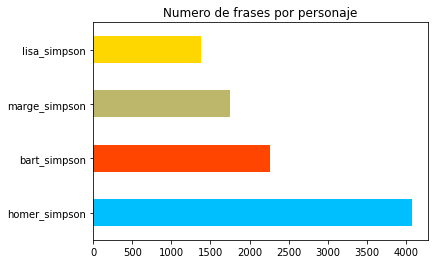

In [9]:
#Gráfico de barras de numero de frases por personaje
frec = pd.value_counts(labels)
plot = frec.plot(kind='barh',title='Numero de frases por personaje',color=['deepskyblue','orangered','darkkhaki','gold'])

In [10]:
sentences[:4]

['wheres mr bergstrom',
 'that life is worth living',
 'victory party under the slide',
 'mr bergstrom mr bergstrom']

# Separa datos de entrenamiento y validación 

In [11]:
train_size = int(len(sentences) * training_portion)

train_sentences = sentences[:train_size]
train_labels = labels[:train_size]

validation_sentences = sentences[train_size:]
validation_labels = labels[train_size:]

print(train_size)
print(len(train_sentences))
print(len(train_labels))
print(len(validation_sentences))
print(len(validation_labels))

# Expected output (if training_portion=.8)
# 126651 train
# 31663 validation

7571
7571
7571
1893
1893


In [12]:
train_sentences[:3]

['wheres mr bergstrom',
 'that life is worth living',
 'victory party under the slide']

In [13]:
train_labels[:3]

['lisa_simpson', 'lisa_simpson', 'bart_simpson']

# Tokens

In [0]:
#juntamos todo el texto en una sola linea
wordtk = ' '.join(train_sentences)

In [15]:
#para dividir las frases
tokenstk = regexp_tokenize(wordtk, pattern="\w+")
tokenstk[:10]

['wheres',
 'mr',
 'bergstrom',
 'that',
 'life',
 'is',
 'worth',
 'living',
 'victory',
 'party']

In [16]:
#para generar n-gramas
from nltk.util import ngrams
trigrama = ngrams(tokenstk,3)
trigrama = [' '.join(grams) for grams in trigrama]
trigrama[:5]

['wheres mr bergstrom',
 'mr bergstrom that',
 'bergstrom that life',
 'that life is',
 'life is worth']

In [17]:
len(trigrama)

65708

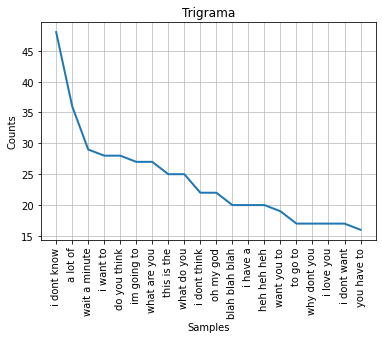

In [18]:
#grafica con los trigramas
freq = nltk.FreqDist(trigrama) #frecuencia de los tokens
freqnew = [] #filtramos tokens que se repiten mas de una vez
for key,val in freq.items():
  if (val>1):
    freqnew.append(str(key))
freq.plot(20, cumulative=False, title = "Trigrama")

In [19]:
len(freqnew)

3850

In [0]:
##para generar n-gramas
#from nltk.util import ngrams
#cuatrigrama = ngrams(tokenstk,4)
#cuatrigrama = [ ' '.join(grams) for grams in cuatrigrama]

In [0]:
#grafica con los cuatrigramas
#freq = nltk.FreqDist(cuatrigrama)
#freq.plot(20, cumulative=False, title = "cuatrigrama")

In [0]:
#print(len(cuatrigrama))

# Vocabulario

In [0]:
corpus = train_sentences

In [22]:
tokenizer=Tokenizer()

# Tokenizing the Corpus
tokenizer.fit_on_texts(corpus)
# We have all the top words on the dictionary + Out Of Vocabulary Word (OOV)
total_words = len(tokenizer.word_index)+1

print('Dictionary: ',tokenizer.word_index,'\n')
print('Total Words in the Tokenizer (+OOV) =',total_words,'\n')

# Show Part of Corpus
print('Corpus: \n')
corpus[0:10]

Dictionary:  {'you': 1, 'i': 2, 'the': 3, 'a': 4, 'to': 5, 'and': 6, 'it': 7, 'of': 8, 'that': 9, 'my': 10, 'is': 11, 'this': 12, 'me': 13, 'in': 14, 'oh': 15, 'for': 16, 'your': 17, 'im': 18, 'what': 19, 'no': 20, 'do': 21, 'have': 22, 'dont': 23, 'on': 24, 'be': 25, 'well': 26, 'we': 27, 'but': 28, 'its': 29, 'all': 30, 'just': 31, 'homer': 32, 'bart': 33, 'was': 34, 'know': 35, 'dad': 36, 'not': 37, 'are': 38, 'can': 39, 'get': 40, 'so': 41, 'marge': 42, 'like': 43, 'with': 44, 'hey': 45, 'youre': 46, 'right': 47, 'thats': 48, 'if': 49, 'up': 50, 'now': 51, 'think': 52, 'he': 53, 'go': 54, 'how': 55, 'at': 56, 'out': 57, 'got': 58, 'one': 59, 'were': 60, 'ill': 61, 'good': 62, 'yeah': 63, 'lisa': 64, 'here': 65, 'about': 66, 'there': 67, 'cant': 68, 'little': 69, 'see': 70, 'look': 71, 'come': 72, 'did': 73, 'they': 74, 'could': 75, 'uh': 76, 'want': 77, 'time': 78, 'going': 79, 'him': 80, 'as': 81, 'gonna': 82, 'when': 83, 'our': 84, 'boy': 85, 'why': 86, 'some': 87, 'ive': 88, 'ok

['wheres mr bergstrom',
 'that life is worth living',
 'victory party under the slide',
 'mr bergstrom mr bergstrom',
 'do you know where i could find him',
 'the train how like him traditional yet environmentally sound',
 'i see he touched you too',
 'hey thanks for your vote man',
 'well you got that right thanks for your vote girls',
 'well dont sweat it just so long as a couple of people did right milhouse']

In [23]:
# Example:
# say your prayers little one

test_seq = []

# First line on corpus
print('First Line = ',corpus[0],'\n')

# Transform first line to sequences according to the dictionary
token_test=tokenizer.texts_to_sequences([corpus[0]])[0]
print('First Line into Sequence =',token_test,'\n')

# Create fragments of the line and make the data by ordered pieces
for j in range(1, len(token_test)):
  # Iterator over the elements of the line
  n_gram_test=token_test[:j+1]
  print('n-gram =',n_gram_test)
  # Append all sequential results
  test_seq.append(n_gram_test)
  print('sequence = ',test_seq,'\n')

# Determine longest n-gram
max_seq_test_len = max([len(x) for x in test_seq])
# Padding
test_seq = np.array(pad_sequences(test_seq, maxlen=max_seq_test_len, padding='pre'))
print("Final n-gram Data:\n\n",  test_seq,'\n')
print('Shape of Data: ',np.shape(test_seq))

First Line =  wheres mr bergstrom 

First Line into Sequence = [327, 106, 821] 

n-gram = [327, 106]
sequence =  [[327, 106]] 

n-gram = [327, 106, 821]
sequence =  [[327, 106], [327, 106, 821]] 

Final n-gram Data:

 [[  0 327 106]
 [327 106 821]] 

Shape of Data:  (2, 3)


# Transform target to one-hot codification

In [0]:
# Creating the Text Sequence for creating training data 

input_sequences = []
for line in corpus:
  token_list = tokenizer.texts_to_sequences([line])[0]
  for i in range(1, len(token_list)):
    n_gram_sequence = token_list[:i+1]
    input_sequences.append(n_gram_sequence)

# Padding

max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# Create predictors and labels (labels are the final word of each sequence. Ex: Data: Say your prayers little, Label: one)

xs, labels = input_sequences[:,:-1], input_sequences[:,-1]

# One-Hot Encoding

ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)

In [25]:
xs

array([[   0,    0,    0, ...,    0,    0,  327],
       [   0,    0,    0, ...,    0,  327,  106],
       [   0,    0,    0, ...,    0,    0,    9],
       ...,
       [   0,    0,    0, ...,   82,  433,  248],
       [   0,    0,    0, ...,  433,  248,    3],
       [   0,    0,    0, ...,  248,    3, 1566]], dtype=int32)

In [26]:
ys

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

# Arquitectura del Modelo

In [0]:
# Tensor Management
import tensorflow as tf
# For Padding
from tensorflow.keras.preprocessing.sequence import pad_sequences
# For Different Types of RNN
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
# For Tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
# Sequential DNN
from tensorflow.keras.models import Sequential
# Array Management
import numpy as np

In [29]:
model = Sequential()
model.add(Embedding(total_words, 64, input_length = max_sequence_len-1))
model.add(Bidirectional(LSTM(20)))
model.add(Dense(total_words,activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics =['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 86, 64)            434880    
_________________________________________________________________
bidirectional (Bidirectional (None, 40)                13600     
_________________________________________________________________
dense (Dense)                (None, 6795)              278595    
Total params: 727,075
Trainable params: 727,075
Non-trainable params: 0
_________________________________________________________________


# Entrenamiento del Modelo

In [0]:
history = model.fit(xs,ys,epochs=100,verbose=2)